In [1]:
%pylab inline

import numpy as np
import pandas as pd
from __future__ import division
from lasagne import layers
from nolearn.lasagne import NeuralNet, TrainSplit
from nolearn.lasagne.visualize import plot_loss
from lasagne.updates import adadelta
from lasagne.nonlinearities import very_leaky_rectify
from scipy.stats import spearmanr
from sklearn.utils import shuffle
import cPickle as pickle
import theano
import os
import gc

def plot_results(net, y1, y2, x2): 
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    pyplot.plot(train_loss, linewidth=3, label="train")
    pyplot.plot(valid_loss, linewidth=3, label="valid")
    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("loss")
    pyplot.ylim(y1, y2)
    pyplot.xlim(-50, x2)
    pyplot.show()
    
def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
        
class PickleModel(object):
    def __init__(self, freq=10):
        self.freq = freq

    def __call__(self, nn, train_history):
        epoch = train_history[-1]['epoch']
        
        if epoch % self.freq == 0:
            with open('net_int.pickle', 'wb') as f:
                pickle.dump(nn, f, -1)
        
        
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()
            
            
def mean_cor(y, yhat):
    nrows = y.shape[0]
    cors = []
    
    # get correlation between each predicted and actual sample
    for i in range(nrows):
        cors.append(spearmanr(y[i, :], yhat[i, :])[0])
        
    return np.mean(cors)

def accuracy(y, yhat):
    num_equal = np.sum(np.sign(y) == np.sign(yhat))
    num_total = y.shape[0] * y.shape[1]
    
    return(num_equal / num_total * 1.0)

def mae(y, yhat):
    return np.mean(np.absolute(y-yhat))

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled)
/home/alex/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Populating the interactive namespace from numpy and matplotlib


In [2]:
# load data
X = np.load('data/X.npy')
y = np.load('data/y.npy')

# X = X.astype(np.float32)
# y = y.astype(np.float32)
# np.save('data/X', X)
# np.save('data/y', y)

In [3]:
# shuffle data
ids = shuffle(range(y.shape[0]), random_state=0)
X = X[ids]
y = y[ids]

gc.collect()

366

<hr />
## Configuration:
<hr />

* <b>hidden layers:</b>
* <b>dropout:</b>
* <b>epochs:</b>

<b>Summary of Changes:</b> <br>


    
<hr />

In [10]:
net = NeuralNet(
    layers=[
        ('input',   layers.InputLayer),
        ('dropout1', layers.DropoutLayer),
        ('hidden',  layers.DenseLayer),
        ('dropout2', layers.DropoutLayer),
        ('output',  layers.DenseLayer),
        ],
    # layer parameters:
    input_shape         = (None, X.shape[1]),  
    dropout1_p          = 0.6,
    dropout2_p          = 0.25,
    hidden_num_units    = 2000,
    hidden_nonlinearity = very_leaky_rectify,
    output_nonlinearity = None,  
    output_num_units    = y.shape[1],
    train_split         = TrainSplit(eval_size = 0.0),

    # optimization method:
    update        = adadelta,
    regression    = True, 
    max_epochs    = 1500,
    verbose       = 1,
    custom_scores = [("spr", lambda y, yhat: mean_cor(y, yhat)),
                     ("acc", lambda y, yhat: accuracy(y, yhat)),
                     ("mae", lambda y, yhat: mae(y, yhat))],
    )

np.random.seed(0)
net.fit(X, y)

# Neural Network with 23060042 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input       3483
  1  dropout1    3483
  2  hidden      2000
  3  dropout2    2000
  4  output      8042

  epoch    train loss    valid loss    train/val    spr    acc    mae  dur
-------  ------------  ------------  -----------  -----  -----  -----  -----
      1       3.43482           nan          nan    nan    nan    nan  0.43s
      2       2.77380           nan          nan    nan    nan    nan  0.43s
      3       2.51847           nan          nan    nan    nan    nan  0.40s
      4       2.32694           nan          nan    nan    nan    nan  0.39s
      5       2.19139           nan          nan    nan    nan    nan  0.39s
      6       2.07040           nan          nan    nan    nan    nan  0.39s
      7       1.96493           nan          nan    nan    nan    nan  0.39s
      8       1.88553           nan          nan    nan    nan    nan  0.39s
  

/home/alex/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fa980031c10>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fa980031ad0>,
     custom_scores=[('spr', <function <lambda> at 0x7fa9685ca488>), ('acc', <function <lambda> at 0x7fa968440230>), ('mae', <function <lambda> at 0x7fa968527410>)],
     dropout1_p=0.6, dropout2_p=0.25,
     hidden_nonlinearity=<lasagne.nonlinearities.LeakyRectify object at 0x7fa980c32dd0>,
     hidden_num_units=2000, input_shape=(None, 3483),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout2', <class 'lasagne.layers.noise.DropoutLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1500, more_params={},
     objective=<function objective at 0x7fa980039938>,
     objective_loss_function=<function squared_

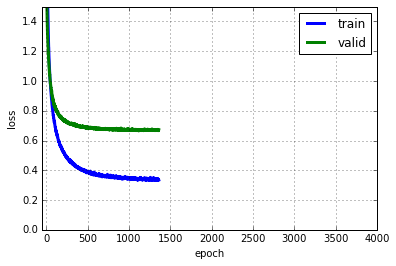

In [9]:
plot_results(net, 0, 1.5, 4000)

<hr />
<div align="center"> 
## Validation:
</div>
<hr />

| Hidden  | Dropout | Update  | Activation | Epochs | Train Loss  | Val Loss | Train/Val  | spr  | acc  | mae  | 
| --------| ------- | ------  | ---------- | ------ |------------ | -------- | ---------- |----- | ---- | ---  |
| 1000    | 0.2     |adadelta | vlReLU     | 1876   | 0.119       |  0.675   |  0.177     |0.570 |0.703 |0.522 |
| 1000    | 0.4     |adadelta | vlReLU     | 1189   | 0.175       |  0.664   |  0.264     |0.575 |0.704 |0.516 |
| 1000    | 0.6     |adadelta | vlReLU     | 1458   | 0.210       |  0.674   |  0.312     |0.571 |0.703 |0.519 |
| 2000    | 0.6     |adadelta | vlReLU     | 1125   | 0.202       |  0.667   |  0.303     |0.576 |0.704 |0.516 |
| 4000    | 0.6     |adadelta | vlReLU     | 796    | 0.226       |  0.667   |  0.339     |0.575 |0.704 |0.517 |
| 2000    | 0.6_0.1 |adadelta | vlReLU     | 818    | 0.296       |  0.662   |  0.447     |0.580 |0.706 |0.516 |
| 2000    | 0.6_0.2 |adadelta | vlReLU     | 1441   | 0.313       |  0.662   |  0.472     |0.582 |0.707 |0.515 |
| 2000    | 0.6_0.25|adadelta | vlReLU     | 1358   | 0.337       |  0.666   |  0.506     |0.579 |0.706 |0.518 |
| 2000    | 0.6_0.3 |adadelta | vlReLU     | 872    | 0.379       |  0.676   |  0.561     |0.573 |0.704 |0.522 |
| 2000    | 0.6_0.4 |adadelta | vlReLU     | 1134   | 0.430       |  0.691   |  0.622     |0.568 |0.701 |0.527 |
| 1000    | 0.7     |adadelta | vlReLU     | 824    | 0.283       |  0.681   |  0.415     |0.566 |0.700 |0.523 |
| 1000    | 0.8     |adadelta | vlReLU     | 816    | 0.353       |  0.706   |  0.499     |0.555 |0.695 |0.534 |
| 1000    | 0.9     |adadelta | vlReLU     | 1071   | 0.552       |  0.782   |  0.705     |0.522 |0.682 |0.561 |


<hr />
<div align="center"> 
## Test:
</div>
<hr />



| Hidden  | Dropout | Update  | Activation | Epochs | acc  | mae  | 
| --------| ------- | ------  | ---------- | ------ | ---- | ---  |
| 2000    | 0.6_0.3 |adadelta | vlReLU     | 872    |0.580 |1.478 |


<hr />
## Prediction:
<hr />

In [11]:
# load test data

Xtest = np.load('data/Xtest.npy')
ytest = np.load('data/ytest.npy')

#Xtest = Xtest.astype(np.float32)
#ytest = ytest.astype(np.float32)
#np.save('data/Xtest', Xtest)
#np.save('data/ytest', ytest)

In [12]:
# mean absolute error
ypred = net.predict(Xtest)

np.nanmean(np.absolute(ytest - ypred))

1.4786034

In [13]:
# accuracy
notna = ~np.isnan(ytest)
np.sum(np.sign(ytest[notna]) == np.sign(ypred[notna])) / np.sum(notna)

0.58144949748003183

In [22]:
# fraction of ytest that is measured
sum(notna) / (sum(notna) + sum(~notna))

0.74711022341042854

In [17]:
# overwrite nan in ytest with predicted values
ytest[~notna] = ypred[~notna]

In [35]:
# save final results
preds = np.hstack([Xtest, ytest])
pd.DataFrame(preds).to_csv("data/preds.csv", header=False, index=False)